# Notæ 10

# Funcionalidades avanzadas de CPLEX

En la actualidad, los solvers comerciales de PLE cuentan con una amplia variedad de mecanismos adicionales que pueden ser utilizados y configurados por el usuario (nosotros). Algunos de ellos ya los hemos utilizado a lo largo del curso, por ejemplo el mecanismo de MIP start para proveer cotas primales. Estos mecanismos modifican el comportamiento del solver, permitiendo muchas veces mejorar su performance. La aplicabilidad y efectividad de los mismos depende en general del problema que estemos resolviendo. 

En este notebook veremos algunos mecanismos más avanzados de CPLEX, en particular veremos qué son las *restricciones lazy*, para qué sirven y cómo se implementan. 

## 1. Restricciones lazy

En la actualidad, los solvers de PLE, e.g. CPLEX o GUROBI, proveen mecanismos para manejar bajo demanda algunas de las restricciones de la formulación. Así surge el concepto de **restricciones lazy**, que representan un subconjunto, típicamente grande, del conjunto de restricciones de la formulación, y sin ellas la formulación estaría incompleta (i.e. posiblemente entregue soluciones incorrectas). 

En muchos modelos, puede ser computacionalmente más rápido tratar a algunas restricciones como lazy, en cuyo caso el solver no las incluirá inicialmente, sino que las agregará únicamente cuando estén violadas. 
En general, son útiles en formulaciones que contienen muchas restricciones y muchas de ellas suelen satisfacerse trivialmente.

A diferencia del concepto de desigualdades válidas, las restricciones lazy eliminan soluciones enteras, que de otra forma serían factibles. Es decir, agregar restricciones lazy afectará el conjunto de soluciones factibles *enteras*.
CPLEX siempre se asegura que *todas* las restricciones lazy estén satisfechas antes de designar un punto entero del poliedro como una nueva solución, de lo contrario agregará las lazy violadas a ese nodo del árbol de B\&B y continuará con la resolución de la relajación lineal. El subárbol que se genere a partir de ese nodo heredará las restricciones lazy que se hayan incorporado.

Existen dos estrategias para manejarlas. A continuación veremos cada una de ellas con más detalle.
1. **Pool de restricciones lazy.**
2. **Callback de restricciones lazy.**

## 1.1. Pool de restricciones lazy

Esta estrategia es la más sencilla ya que el solver es quien se ocupa de incorporar las restricciones lazy cuando estén violadas. Esto se logra generando *todas* las restricciones lazy antes de resolver el modelo, pero en lugar de agregarlas al modelo, se agregan en un **pool de restricciones lazy** (podemos pensarlo como un conjunto). Así, CPLEX verifica que se satisfagan todas las restricciones del pool antes de anunciar el hallazgo de una nueva solución entera. Las restricciones que queremos considerar desde el arranque las incoporamos al modelo con el ya conocido método <code>add_constraint</code>, mientras que las lazy las incorporamos al pool con <code>add_lazy_constraint</code>.

Para ejemplificar esta estrategia seguiremos como caso de estudio el **Problema de Ordenamiento Lineal**. 

**Definición.** Sea $D_n =(V_n,A_n)$ el **digrafo completo** de $n$ nodos, es decir, el grafo dirigido con conjunto de vértices $V = \{0,\ldots,n-1\}$ y la propiedad de que para todo par de nodos distintos $i$ y $j$, hay un arco $(i,j)$ de $i$ a $j$ y un arco $(j,i)$ de $j$ a $i$.

**Definición.** Un **torneo** $T$ en $A_n$ es un subconjunto de arcos que contiene, para todo par de nodos distintos $i$ y $j$, alguno de los arcos $(i,j)$ o $(j,i)$, pero no ambos.

**Definición.** Un **torneo acíclico** es un torneo sin ciclos dirigidos, es decir, que no contiene un conjunto de arcos de la forma $\{(v_1,v_2), (v_2,v_3), \ldots, (v_k,v_1)\}$ para algún entero $k>1$ y nodos distintos $v_1,v_2,\ldots,v_k$.

### &#x1f4bb; Actividad 1

Diseñar las siguientes funciones:

* <code>digrafo_completo</code> que, dado un número natural $n$, retorne el digrafo completo $D_n$.
* <code>es_torneo</code> que, dados un digrafo completo $D$ y una lista de arcos $T$, determine si $T$ es un torneo para $D$.
* <code>es_torneo_aciclico</code> que, dados un digrafo completo $D$ y una lista de arcos $T$, determine si $T$ es un torneo acíclico para $D$. Pueden ser de utilidad las funciones edge_subgraph y find_cycle de <code>NetworkX</code>, las puede investigar.

Recordar escribir casos de prueba para estas funciones.

In [1]:
import networkx as nx

## Espacio para resolver Actividad 1

def digrafo_completo(n):
    # Completar
    raise Exception("Función no implementada")

def es_torneo(D, T):
    # Completar
    raise Exception("Función no implementada")
    
def es_torneo_aciclico(D, T):
    # Completar
    raise Exception("Función no implementada")

**Definición.** Un **ordenamiento lineal** de los nodos $\{0,1,\ldots,n-1\}$ es un *ranking* de los nodos dados por una secuencia lineal, o equivalentamente, una permutación de los nodos. Denotamos $\langle v_0, v_1, \ldots v_{n-1} \rangle$ al ordenamiento lineal que rankea primero al nodo $v_0$, segundo a $v_1$, etc., y último a $v_{n-1}$. Si $\sigma$ denota un ordenamiento lineal, entonces $\sigma(i)$ representa la posición del nodo $i$ es este ordenamiento. 

**Observación.** Todo torneo acíclico $T$ en $A_n$ se corresponde con un ordenamiento lineal de los nodos de $V_n$, y viceversa: el nodo rankeado primero es el único que no tiene arcos de entrada en $T$, el nodo rankeado segundo es el único que tiene un arco de entrada en $T$ (proveniente del nodo rankeado primero), etc., y el nodo rankeado último es el único que no tiene arcos de salida en $T$.

Usualmente, las relaciones de orden son ponderadas, y tenemos un peso $c_{ij}$ que representa el beneficio que resulta cuando $i$ es rankeado antes que $j$, o equivalentemente, cuando el arco $(i,j)$ pertenece al torneo acíclico. Luego, el **Problema de Ordenamiento Lineal (LOP, del inglés Linear Ordering Problem)** se define como sigue.

**Problema de Ordenamiento Lineal (LOP)**</br>
**Entrada.** Digrafo completo $D_n = (V_n, A_n)$ con costos de arco $c_{ij}$ para todo $(i,j) \in A_n$.</br>
**Objetivo.** Encontrar un torneo acíclico $T$ en $A_n$ tal que $\sum_{(i,j) \in T} c_{ij}$ es tan grande como sea posible.

Una formulación de PLE para resolver el LOP está motivada por el siguiente lema.

**Lema.** Dados un digrafo completo $D_n = (V_n, A_n)$ y un torneo $T$ en $A_n$, $T$ es un torneo acíclico si y sólo si $T$ no contiene un conjunto de arcos de la forma $\{(v_0,v_1),(v_1,v_2),(v_2,v_0)\}$ con $v_0,v_1,v_2$ nodos distintos en $V_n$, o equivalentemente, el subdigrafo inducido $D_n[T]$ no contiene ciclos dirigidos de largo 3.

Se considera una variable de decisión (binaria) $x_{ij}$ para todo $(i,j) \in A_n$, tal que $x_{ij} = 1$ si y sólo si $i$ precede a $j$ en el orden. Luego, tenemos la siguiente formulación.

\begin{align*}
\text{Maximizar:} ~~~ & \sum_{(i,j) \in \mathcal A_n} c_{ij}x_{ij} \tag{1} \\
\text{Sujeto a:} ~~~ & x_{ij} + x_{ji} = 1 & \forall~i,j \in V_n,~ i < j . \tag{2}\\
& x_{ij} + x_{jk} + x_{ki} \leq 2 & \forall~i,j,k \in V_n,~ i < j,~ i < k,~ j \neq k. \tag{3} \\
& x_{ij} \in \{0,1\} & \forall~i,j \in A_n.
\end{align*}

La función objetivo (1) maximiza el peso total de $T$. Las restricciones (2) aseguran que $i$ precede a $j$ o viceversa, pero no ambas. Las restricciones (3) prohiben ciclos dirigidos de largo 3. Notar que piden $i < j,~ i < k,~ j \neq k$ para evitar escribir múltiples restricciones para un mismo ciclo (cambiando el vértice que se considera como inicial o cambiando el sentido horario u antihorario).

A continuación, se presenta la función <code>construir_modelo_lop</code> que construye este modelo en Python. Esta función toma como argumentos un digrafo completo <code>D</code> y un diccionario <code>C</code> que mapea los arcos con sus pesos. A su vez, usa un diccionario para guardar a las variables <code>X</code>. Esta estrategia de usar un diccionario, aprovechando que se puede indexar por los arcos del digrafo, ya la hemos usado en el notebook 8 para definir a las variables de precedencia en la formulación para el Power Dominating Set Problem. 

In [2]:
from docplex.mp.model import Model

def construir_modelo_lop(D, C):
    
    # Inicializamos el modelo   
    modelo = Model(name='LOP')  
    
    # Diccionario de variables
    X = {(i,j): modelo.binary_var("x_" + str(i) + "_" + str(j)) for i,j in D.edges}
    
    # Funcion objetivo (1)
    modelo.maximize(modelo.sum(C[(i,j)] * X[(i,j)] for i,j in D.edges))
    
    # Restricciones
    for i in D:
        for j in D:
            if j >= i:
                continue
            # Restricciones (2)
            modelo.add_constraint(X[(i,j)] + X[(j,i)] == 1)
            for k in D:
                if k >= i or k == j:
                    continue
                 # Restricciones (3)
                modelo.add_constraint(X[(i,j)] + X[(j,k)] + X[(k,i)] <= 2)

    return modelo

def resolver(modelo, archivo=True):
    
    # Resolvemos el modelo
    sol = modelo.solve(log_output=archivo)
 
    # Retornamos la solucion
    return sol

### &#x1f4bb; Actividad 2

* ¿Cuál es el máximo tamaño de vértices $n$ que puede resolver con este modelo en un tiempo límite de 60 segundos? Comenzar con un valor pequeño de $n$ e ir incrementando su valor en 1 hasta que el tiempo de ejecución exceda el tiempo límite. Para generar los digrafos completos necesitará la función <code>digrafo_completo</code> de la Actividad 1. Para los pesos de los arcos genere números enteros aleatorios entre 0 y 2 (ambos extremos incluidos) y fijando la semilla para la generación en el valor 0 (así todxs trabajamos con los mismos pesos aleatorios). Puede hacer uso de la función <code>generar_pesos</code> que se presenta más abajo, la cual construye el diccionario de pesos a partir del número de vértices, un peso mínimo, un peso máximo y un valor de semilla (por default en 0).
* Para cada instancia generada en el punto anterior, construya un dataframe que muestre el valor de $n$ (número de vértices), el número de retricciones (2), el número de restricciones (3) y el número total de restricciones. ¿Qué proporción del total de restricciones representan las restricciones (3)? ¿Cómo crece esta proporción a medida que aumenta $n$?

In [3]:
import random

def generar_pesos(n, l, u, seed=0):
    random.seed(seed)
    return {(i,j): random.randint(l,u)
               for i in range(n)
               for j in range(n)
               if i != j}

In [4]:
## Ejemplo de uso
n = 5
digrafo = digrafo_completo(n)
pesos = generar_pesos(n, 0, 2)
modelo = construir_modelo_lop(digrafo, pesos)
sol = resolver(modelo, True)
sol.display()

Exception: Función no implementada

In [5]:
## Espacio para resolver Actividad 2

Si ya ha resuelto la Actividad 2 (y sugerimos hacerlo antes de avanzar), habrá notado que la cantidad de restricciones (3) crece mucho más rápidamente que las (2). Si bien ninguna de ellas crece exponencialmente con $n$, las (2) crecen de forma cuadrática y las (3) de forma cúbica. Por lo tanto, incluso para valores de $n$ no tan grandes, tendremos muchas restricciones y la inmensa mayoría de ellas pertenecerán a la familia (3). Tener tantas restricciones puede hacer que cada relajación lineal sea muy pesada de resolver.

Resuelta lógico intentar designar a las restricciones (3) como lazy. Para hacerlo, es necesario cambiar muy poco el código. En lugar de agregarlas con el método <code>add_constraint</code>, usaremos <code>add_lazy_constraint</code>.

In [6]:
def construir_modelo_lop_lazy(D, C):
    
    # Inicializamos el modelo   
    modelo = Model(name='LOP-lazy')  
    
    # Diccionario de variables
    X = {(i,j): modelo.binary_var("x_" + str(i) + "_" + str(j)) for i,j in D.edges}
    
    # Funcion objetivo (1)
    modelo.maximize(modelo.sum(C[(i,j)] * X[(i,j)] for i,j in D.edges))
    
    # Restricciones
    for i in D:
        for j in D:
            if j >= i:
                continue
            # Restricciones (2)
            modelo.add_constraint(X[(i,j)] + X[(j,i)] == 1)
            for k in D:
                if k >= i or k == j:
                    continue
                 # Restricciones (3)
                modelo.add_lazy_constraint(X[(i,j)] + X[(j,k)] + X[(k,i)] <= 2)

    return modelo

Veamos un ejemplo de cómo resolver este modelo y cómo leemos en el log la información del pool de restricciones lazy.

In [7]:
n = 40
digrafo = digrafo_completo(n)
pesos = generar_pesos(n, 0, 2)
modelo = construir_modelo_lop_lazy(digrafo, pesos)
sol = resolver(modelo, True)

Exception: Función no implementada

Durante el preprocesamiento, CPLEX nos informa cuántas restricciones lazy tiene el pool:

<code>Problem contains 19760 lazy constraints.</code>

Al final de la optimización, CPLEX nos informa cuántas restricciones lazy agregó a la formulación (debido a que fueron violadas).

<code>Lazy constraints applied:  3509</code>

Es decir, solo el 17,7% de las restricciones (3) se violaron durante la optimización, lo que reafirma la sospecha de que conviene manejarlas como lazy.

### &#x1f4bb; Actividad 3

* Volver a resolver el primer item de la Actividad 2 usando esta vez el modelo con restricciones lazy. ¿Se observa alguna diferencia?
* Sea $n_1$ y $n_2$ el máximo número de vértices que se puede resolver en 1 minuto con el modelo sin restricciones lazy y con el modelo con restricciones lazy, respectivamente. Computar (o calcular) cuántas restricciones tiene la formulación para un digrafo completo con $n_1$ y con $n_2$ vértices. ¿Cuántas veces más grande (en número de restricciones) es la formulación que se puede resolver al usar las restricciones lazy?

In [8]:
## Espacio para resolver Actividad 3

## 1.2. Callback de restricciones lazy

La estrategia de usar un pool de restricciones lazy nos permitió resolver más rápido la formulación de PLE vista para el LOP. Cabe aclarar que usar restricciones lazy es una decisión meramente de implementación. Es decir, la inteligencia se pone en lo algorítmico y no en lo poliedral.

Otro punto importante a mencionar en el método anterior es que, aunque las restricciones lazy no se agregan en su totalidad a la formulación, si se generan todas y se mantienen en el pool. Por lo que no evitamos el consumo de tiempo y de memoria involucrado en su generación. Esto puede ser especialmente impráctico cuando la familia de restricciones en cuestión crece exponencialmente con el tamaño de la entrada. En esos casos, el segundo método que veremos para manejar restricciones lazy sueler ser más adecuado.

La estrategia **callback de restricciones lazy**, al igual que antes comienza resolviendo la formulación sin ninguna de las restricciones lazy, pero la diferencia ahora es que tampoco se mantienen en un pool de restricciones lazy. En vez de eso, cada vez que el solver encuentra un punto entero, nos delegará (al usuario) la tarea de resolver el problema de separación asociado a las restricciones lazy. Este problema consiste en determinar si el punto entero encontrado por el solver viola alguna restricción lazy. Si no existe ninguna, entonces ese punto es una solución factible de la formulación completa. De lo contrario, se debe encontrar al menos una restricción lazy violada para suministrale al solver. Luego de agregarla, el solver continuará con la resolución de la relajación lineal de ese nodo.

Obviamente surge la pregunta de cómo verificar si un punto entero verifica o no todas las restricciones lazy sin generarlas a todas. Esta tarea no siempre es fácil/posible y en general requiere un profundo estudio teórico del problema y de la estructura de las soluciones. Para ejemplificar estas técnicas seguiremos estudiando el Power Dominating Set Problem (PDS) introducido en el Notebook 8. Buen momento para volver y repasar las definiciones.

Empecemos recordando la formulación para resolver el PDS, propuesta por Brimkov, Mikesell y Smith (2019), https://doi.org/10.1007/s10878-019-00380-7 (sección 6.1). **De ahora en adelante suponemos que el grafo es conexo** (en caso contrario, resolvemos el PDS en cada componente conexa).

\begin{align*}
& \min \sum_{v \in V} s_v & \\
\text{s.a.}\ \ \ & s_v + \sum_{u \in N(v)} y_{uv} = 1 & \forall\ v \in V. \tag{1}\\
& x_u - x_v + (T+1)y_{uv} \leq T & \forall\ (u,v) \in \overrightarrow{E}. \tag{2}\\
& x_w - x_v + (T+1)y_{uv} \leq T + (T+1)s_u & \forall\ (u,v) \in \overrightarrow{E},\ w \in N(u) \setminus \{v\}. \tag{3}\\
& x \in \mathcal T^{V},\ y \in \{0,1\}^{\overrightarrow{E}},\ s \in \{0,1\}^{V}. 
\end{align*}

Esta formulación se implementa en Python con el siguiente código.

In [9]:
def construir_modelo_pds_brimkov(G):
    
    modelo = Model(name='PDS-Brimkov') # Inicializamos el modelo 
    
    # Instantes de tiempo
    T = G.number_of_nodes()
    
    # Digrafo (con aristas dirigidas) asociado a G
    D = G.to_directed()
    
    # Variables
    S = [modelo.binary_var(name='s_' + str(v)) for v in G]
    X = [modelo.integer_var(0, T, name='x_' + str(v)) for v in G]
    Y = {(u,v): modelo.binary_var(name='y_' + str(u) + '_' + str(v)) 
         for u,v in D.edges}

    # Funcion objetivo
    modelo.minimize(modelo.sum(S[v] for v in G))
    
    # Restricciones (1)
    for u in G:
        modelo.add_constraint(S[u] + modelo.sum(Y[(v,u)] for v in G.neighbors(u)) == 1)

    # Restricciones (2)
    for u, v in D.edges:
        modelo.add_constraint(X[u] - X[v] + (T+1)*Y[(u,v)] <= T) 

    # Restricciones (3)
    for u, v in D.edges:
        for w in G.neighbors(u):
            if w == v:
                continue
            modelo.add_constraint(X[w] - X[v] + (T+1)*Y[(u,v)] <= T + (T+1)*S[u])    

    return modelo

### &#x1f4bb; Actividad 4

Diseñar las siguientes funciones:

* <code>monitoreados</code> que, dado un grafo $G$ y un conjunto de vértices $S$, retorne el conjunto $M(S)$ de vértices de $G$ monitoreados por $S$. Usar conjuntos de Python (set) para representar a $S$ y $M(S)$. La función no debe modificar el conjunto $S$ que recibe por argumento. 
* <code>es_pds</code> que, dado un grafo $G$ y un conjunto de vértices $S$, retorne True si y sólo si $S$ es un conjunto dominante energético de $G$.

Recordar incluir casos de prueba.

In [10]:
## Espacio para resolver Actividad 4

def monitoreados(G, S):
    # Completar
    raise Exception("Función no implementada")

def es_pds(G, S):
    # Completar
    raise Exception("Función no implementada")

Hace un par de años se propuso una nueva formulación de PLE para resolver el PDS, ver <a href="https://doi.org/10.1002/net.22056">L. Smith, I. Hicks (2021)</a>. Esta nueva formulación tiene únicamente variables de decisión asociadas a los vértices (las mismas variables binarias $s$ del modelo anterior). Además, tiene una única familia de restricciones, cuyo tamaño puede crecer exponencialmente en el tamaño de la entrada. Antes de presentar la formulación, es necesario introducir algunos conceptos.

**Definición.** Sea un grafo $G = (V,E)$ y un subconjunto de vértices no vacío $F \subseteq V$. Denotamos $N(F) = (\cup_{v \in F} N(v)) \setminus F$, es decir, es el conjunto de vértices que no pertenecen a $F$ pero que son adyacentes a algún vértice de $F$. Denotamos $N[F] = (\cup_{v \in F} N[v])$, o equivalentemente, $N[F] = N(F) \cup F$.

**Definición.** Sea un grafo $G = (V,E)$, un subconjunto de vértices no vacío $F \subseteq V$ es un **fuerte** de $G$ si todo vértice $v \in N(F)$ tiene al menos dos vecinos contenidos en $F$, es decir, $|N(v) \cap F| \geq 2$.

**Ejemplo.** Considerar el siguiente grafo $G$.

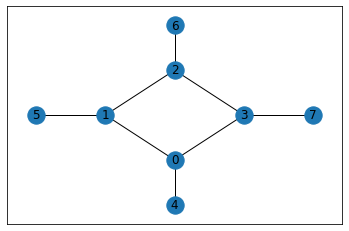

In [11]:
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,3), (3,0), (0,4), (1,5), (2,6), (3,7)])

coordenadas = {0: (2,1), 1: (1,2), 2: (2,3), 3: (3,2), 
               4: (2,0), 5: (0,2), 6: (2,4), 7: (4,2)}
nx.draw_networkx(G, pos=coordenadas)

$F = V(G)$ y, para todo $v \in V(G)$ tal que $\delta(v) >= 2$, $F_v = V(G) \setminus \{v\}$, son trivialmente fuertes. Con estos ejemplos triviales vemos que un fuerte no necesariamente es minimal, pues $F_v \subset F$, para todo $v \in V(G)$ tal que $\delta(v) >= 2$.

Un fuerte más interesante es $F' = \{0,2,4,6\}$. Notar que es un fuerta ya que $N(F') = \{1,3\}$, $N(1) \cap F' = \{0,2\}$ y $N(3) \cap F' = \{0,2\}$. Además, $F'$ es minimal, pues si tiramos cualquier de sus vértices dejaría de ser un fuerte.

### &#x1f4bb; Actividad 5

Diseñar las siguientes funciones:

* <code>es_fuerte</code> que, dado un grafo $G$ y un conjunto de vértices $F$, retorne True si y sólo si $F$ es un fuerte de $G$. Nuevamente usar conjuntos de Python (set) para representar a $F$.
* <code>minimalizar_fuerte</code> que, dado un grafo $G$ y un conjunto de vértices $F$, retorne un fuerte minimal $F' \subseteq F$ de $G$. La función no debe modificar el conjunto $F$ que recibe por argumento.

Recordar incluir casos de prueba.

In [12]:
## Espacio para resolver Actividad 5

def es_fuerte(G, F):
    # Completar
    raise Exception("Función no implementada")

def minimalizar_fuerte(G, F):
    # Completar
    raise Exception("Función no implementada")

Las estructuras que forman los fuertes son extremadamente importantes en el estudio de los conjuntos dominantes energéticos. Por ejemplo, considerar el fuerte $F' = \{0,2,4,6\}$ del grafo $G$ mencionado más arriba. Se puede notar que cualquier conjunto dominante energético tiene que contener al menos un vértice de $N[F'] = \{0,1,2,3,4,6\}$, ya que de lo contrario los vértices de $F'$ no se podrían monitorear por ninguna de las dos reglas. Y esto vale para cualquier fuerte. Más aún, vale la siguiente caracterización.

**Proposición.** Sea un grafo $G = (V,E)$ y un conjunto de vértices $S \subseteq V$, $S$ es un conjunto dominante energético de $G$ si y solo si $S \cap N[F] \neq \emptyset$ para todo fuerte $F$ de $G$.

Esto motiva la siguiente formulación de PLE para el PDS. Notamos con $\mathcal{F}$ al conjunto de todos los fuertes de $G$.

\begin{align*}
\min & \sum_{v \in V} s_v & \\
\text{s.a.}& \sum_{v \in N[F]} s_v \geq 1 & \forall\ F \in \mathcal{F}. \tag{1}\\
& s \in \{0,1\}^{V}. 
\end{align*}

Como ya hemos observado, no es necesario considerar al conjunto $\mathcal{F}$ de todos los fuertes de $G$, sino que basta con considerar los minimales (pensar cómo probar que la restricción asociada a un fuerte minimal $F'$ domina a las asociadas a cualquier fuerte $F$ que contenga a $F'$). Si bien esto puede ayudarnos un poco, desde la teoría de la complejidad computacional, seguimos tratando con un problema difícil. Por un lado, está probado que hay familias de grafos que pueden tener una cantidad exponencial de fuertes minimales. Por el otro, si quisiéramos generarlas a todas, necesitaríamos un algoritmo que encuentre todos los fuertes minimales del grafo, y esto no parece trivial.

Aquí es donde la estrategia **callback de restricciones lazy** puede ser útil. De hecho, y como veremos a continuación, encontrar una restricción (1) violada por un punto entero es un problema muy fácil de resolver, y de hecho lo vamos a resolver. Seguiremos las ideas de este trabajo <a href="https://doi.org/10.4230/LIPIcs.ESA.2023.21">T. Bläsius y M. Göttlicher (2023)</a>.

Vamos a mostrar la idea mediante un ejemplo. Volvamos al grafo $G$ de más arriba. Consideremos un conjunto de vértices que no sea un conjunto dominante energético, por ejemplo $S= \{0\}$, ya que $M(S) = \{0,1,3,4\} \neq V(G)$. Por la proposición vista, debe existir un fuerte $F$ tal que $N[F] \cap S = \emptyset$. Busquemos tal fuerte.

In [13]:
S = {0}
MS = monitoreados(G, S) # Funcion de la Actividad 4
nx.draw_networkx(G, pos=coordenadas, node_color=["red" if v in MS else "#1f78b4"
                                                       for v in G])

Exception: Función no implementada

Observar que el conjunto de vértices azules $\overline{M(S)} = \{2,5,6,7\}$ es un fuerte (**¡probarlo!**). Por lo tanto, si se considera el vector característico $s^S$ de $S$, es decir, dado $v \in V$, $s^S_v = 1$ si y sólo si $v \in S$, entonces se tiene que la restricción asociada a este fuerte $\overline{M(S)}$ está violada por el punto entero $s^S$:

$$\sum_{v \in N[\overline {M(S)}]} s^S_v = \sum_{v \in \{1,2,3,5,6,7\}} s^S_v = 0 \not \geq 1 $$

Se puede probar que esto ocurre para cualquier conjunto de vértices $S$ que no sea un conjunto dominante energético. Tenemos el siguiente lema.

**Lema.** Sea un grafo $G = (V,E)$ y un conjunto de vértices $S \subseteq V$ tal que $S$ no es un conjunto dominante energético, entonces $\overline{M(S)}$ es un fuerte y $N[\overline{M(S)}] \cap S = \emptyset$.

Por el contrario, si $S$ fuese un conjunto dominante energético, entonces por proposición sabemos que no existe un fuerte $F$ tal que $N[F] \cap S \neq \emptyset$, o equivalentemente el punto $s^S$ verifica todas las desigualdades asociadas a los fuertes. 

Por lo tanto, ¡queda resuelto el problema de separación asociado a estas restricciones!

Si bien es posible derivar un algoritmo que resuelva el problema de separación en base al análisis de recién, los autores del paper notan que los fuertes suministrados por este procedimiento podrían no ser minimales (esto no sucede en el ejemplo anterior). Ok, esto no es un problema tan grave, ya que podríamos minimalizar el fuerte encontrado. Sin embargo, se encontraría a lo sumo una restricción de fuerte violada. En general, es conveniente agregar un mayor número de restricciones violadas a la vez, ya que además de cortar el punto entero recién encontrado por el solver, también se cortarían otros puntos enteros *parecidos* (cercanos en el poliedro), lo que evitaría a futuro resolver algunos problemas de separación.

Para resolver esto, los autores del paper proponen el siguiente algoritmo para resolver el problema de separación. Dado un grafo $G$ y un subconjunto de vértices $S$, denotan $S_0 = S \cup \overline{M(S)}$ y $m = \overline{M(S)}$. Notar que $S_0$ es un conjunto dominante energético (**¡probarlo!**), aunque no necesariamente minimal. Sea $\sigma$ un ordenamiento (permutación) aleatorio de los vértices de $\overline{M(S)}$, donde para $i \in \{1, \ldots, m\}$, $\sigma_i$ es el vértice de la $i$-ésima posición. En cada iteración $i \in \{1, \ldots, m\}$, se define el conjunto $S_i$ en base a $S_{i-1}$:

* Si $S_{i-1}$ es un conjunto dominante energético, $S_i = S_{i-1} \setminus \{\sigma_i\}$.
* Si $S_{i-1}$ no es un conjunto dominante energético, $S_i = (S_{i-1} \cup \{\sigma_{i-1}\}) \setminus \{\sigma_i\}$. 

Para cada $S_i$, con $i \in \{1, \ldots, m\}$, tal que $S_i$ no sea un conjunto dominante energético, se genera una restricción violada asociada al fuerte que se obtiene de minimalizar el fuerte $\overline {M(S_i)}$.

Por lo tanto, con este procedimiento se generan entre $1$ y $m$ restricciones lazy violadas, de forma aleatoria. Además, cada $S_i$ es *casi* un conjunto dominante energético minimal, pues se transforma en uno al incoporarle el vértice $\sigma_{i-1}$, por lo que cada fuerte tiende a ser chico (ya que el $M(S_i)$ es grande). Este algoritmo se puede implementar con la siguiente función:

In [14]:
def buscar_fuertes(G, S):
    
    # MS: Conjunto de vertices monitoreados por S
    MS = monitoreados(G, S)
    # NS: Conjunto de vertices no monitoreados por S
    NS = set(G.nodes).difference(MS)
    # S0: Conjunto dominante energetico inicial
    S0 = S.union(NS)
    # fuertes: Lista de fuertes, inicialmente vacía
    fuertes = []
    # orden: Lista con los vertices no monitoreados
    orden = list(NS)
    random.shuffle(orden) # Mezclar la lista aleatoriamente
    
    for u in orden:
        # Generamos Si (reutilizamos S0)
        S0.remove(u)
        if not es_pds(G, S0):
            # Generamos el fuerte, que es el complemento de los monitoreados por Si
            fuerte = set(G.nodes).difference(monitoreados(G, S0))
            # Lo minimalizamos
            fuerte = minimalizar_fuerte(G, fuerte)
            # Lo agregamos a la lista de fuertes
            fuertes.append(fuerte)
            # Volvemos a insertar el último vértice removido
            S0.add(u)
    
    return fuertes

Ejemplo de aplicación para $S = \{0,4\}$.

In [15]:
buscar_fuertes(G, {0,4})

Exception: Función no implementada

Notar que si en el nodo raíz no se agrega inicialmente ninguna restricción lazy, la formulación no tendrá restricciones. Es decir, su relajación lineal tendrá como solución óptima al vector nulo (todas las variables en cero). Por lo tanto, el primer problema de separación a resolver será para $S = \emptyset$. Veamos qué retorna la función en ese caso.

In [16]:
buscar_fuertes(G, set())

Exception: Función no implementada

Es muy común que la formulación no inicie sin ninguna restricción lazy, sino que se suele usar un subconjunto inicial de restricciones lazy. Esto busca evitar iniciar con una relajación lineal muy débil. Por lo tanto, los autores del paper generan inicialmente una restricción lazy por cada fuerte encontrado por <code>buscar_fuertes(G, set())</code>, esto lo hacen durante la construcción del modelo. Como se presenta a continuación.

In [17]:
def construir_modelo_pds_fort_aux(G):
    
    assert nx.is_connected(G), "El grafo de entrada es no-conexo."
    
    # Inicializar el modelo
    modelo = Model(name='PDS-Fort')
    
    # Variables
    X = [modelo.binary_var(name='s_' + str(v)) for v in G]
    
    # Función objetivo
    modelo.minimize(modelo.sum(X[v] for v in G)) 
    
    # Restricciones lazy iniciales
    Fs = buscar_fuertes(G, set())
    for F in Fs:
        NF = vecindad_cerrada(G, F)
        modelo.add_constraint(modelo.sum(X[v] for v in NF) >= 1)
        
    return modelo

# Funcion que dado F retorna N[F]
def vecindad_cerrada(G, F):
    return {u for v in F for u in G.neighbors(v)}

Lo único que queda es indicarle a CPLEX que queremos usar un **callback de restricciones lazy**. Primero definamos este callback, es decir, la función que CPLEX ejecutará cada vez que encuentre un punto entero, y su tarea será resolver el problema de separación. Esta parte se va a poner un poco más técnica, pero no hay otra manera de hacerlo.

Un callback es una clase definida en el paquete <code>cplex</code> de nombre <code>LazyConstraintCallback</code>. Para definir nuestro propio callback, tenemos que definir una clase que *herede* de esta (la herencia significa que la clase comparte los atributos y métodos de su padre, pero permite sobreescribir algunos de ellos). Nuestra clase se llamará <code>LazyFort</code> y en Python la herencia se escribe 

<code>class LazyFort(LazyConstraintCallback):</code>.

Vamos a sobreescribir dos métodos de la clase <code>LazyConstraintCallback</code>. El primero es el método <code>__init__</code>, que lo usaremos para indicarle a Python que esta clase tendrá un atributo <code>G</code> que usaremos para guardar el grafo de entrada. También reescribiremos el método <code>__call__</code> que se ocupará de resolver el problema de separación. 


Para resolver el problema de separación, primero generamos el conjunto <code>S</code> de vértices cuyas variables estén prendidas. Para acceder al grafo, tendremos que escribir <code>self.G</code>, dado que ahora es un atributo de la clase. Luego, buscamos los fuertes y agregamos las restricciones lazy violadas al modelo.  Para agregar al restricción se usa el método <code>add</code>, que toma la lista de variables, la lista de coeficientes de las variables (en nuestro caso todos 1s),  una "G" para indicar que la restricción es de mayor o igual, y el valor del lado derecho de la restricción (en nuestro caso es 1).

In [18]:
from cplex.callbacks import LazyConstraintCallback

class LazyFort(LazyConstraintCallback):

    def __init__(self, env):
        super().__init__(env)
        self.G = None

    def __call__(self):

        S = {v for v in self.G if self.get_values("s_" + str(v)) > 0.5}
        if es_pds(self.G, S):
            return
        
        Fs = buscar_fuertes(self.G, S)
        for F in Fs:
            NF = vecindad_cerrada(self.G, F)
            variables = ["s_" + str(v) for v in NF]
            coeficientes = [1] * len(NF)
            self.add([variables, coeficientes], "G", 1) 
        return

Lo único que nos queda es agregar el callback al modelo e inicializar el atributo <code>G</code> de la clase.

In [19]:
def construir_modelo_pds_fort(G):
    modelo = construir_modelo_pds_fort_aux(G)
    cb = modelo.register_callback(LazyFort)
    cb.G = G
    return modelo

Probemos nuestro modelo.

In [20]:
grafo = nx.erdos_renyi_graph(30, 0.5, seed=0)
modelo = construir_modelo_pds_fort(grafo)
sol = resolver(modelo)

Exception: Función no implementada

En el log podemos ver la siguiente información:

<code>Legacy callback                                  LD
Warning: Control callbacks may disable some MIP features.
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
</code>


Esto significa que CPLEX está usando un callback de restricciones lazy y por ende algunas funcionalidades de CPLEX se desactivaron (aquellas que son incompatibles al usar este tipo de callback, como por ejemplo las reducciones duales en el preprocesamiento).

Otra diferencia importante del log es:

<code>MIP search method: traditional branch-and-cut.</code>

Esto quiere decir que CPLEX cambia el método de búsqueda, en lugar de usar su potente algoritmo de **dynamic search**, cambia a B\&C tradicional. Vale la pena aclarar que dynamic search es una implementación propia de IBM y no se conoce públicamente como trabaja, pero en la práctica suele funcionar mucho mejor que B\&C tradicional. Este cambio en el método de búsqueda se produce nuevamente porque estamos usando un callback que es incompatible con dynamic search.

Finalmente, CPLEX nos comunica el número de restricciones lazy agregadas (tener en cuenta que este número cambia en cada corrida debido a la aleatoriedad en la búsqueda de los fuertes):

<code>User cuts applied:  25</code>

### &#x1f4bb; Actividad 6

* Generar un grafo aleatorio de 20 vértices para cada una de las siguientes propabilidades de arco: 0.25, 0.5, 0.75. Procure que el grafo sea conexo. Resuelver el problema de PDS para esas intancias usando los dos algoritmos desarrollados: el que resuelve la formulación de Brimkov y el que resuelve la formulación de Smith (con el callback de restricciones lazy propuesto por Blasius). Comparar los resultados obtenidos.
* Eligir una de las probabilidades de arco del item anterior y evaluar los límites del algoritmo que usa el callback de restricciones lazy, es decir, el máximo número de vértices del grafo que logra resolver en menos de un minuto.
* ¿Qué se puede concluir?

In [21]:
# Espacio para resolver Actividad 6